In [2]:
!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

df = pd.read_excel('Dados/Dados_Oiv/Dados_Oiv.xlsx', 
                   engine='openpyxl')
df.head()


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,Continent,Region/Country,Product,Variable,Year,Unit,Quantity
0,Asia,Afghanistan,Wine,Consumption,2009,1000 hl,3
1,Asia,Afghanistan,Wine,Imports,2009,1000 hl,3
2,Asia,Afghanistan,Wine,Production,2009,1000 hl,0
3,Asia,Afghanistan,Wine,Consumption,2010,1000 hl,2
4,Asia,Afghanistan,Wine,Imports,2010,1000 hl,2


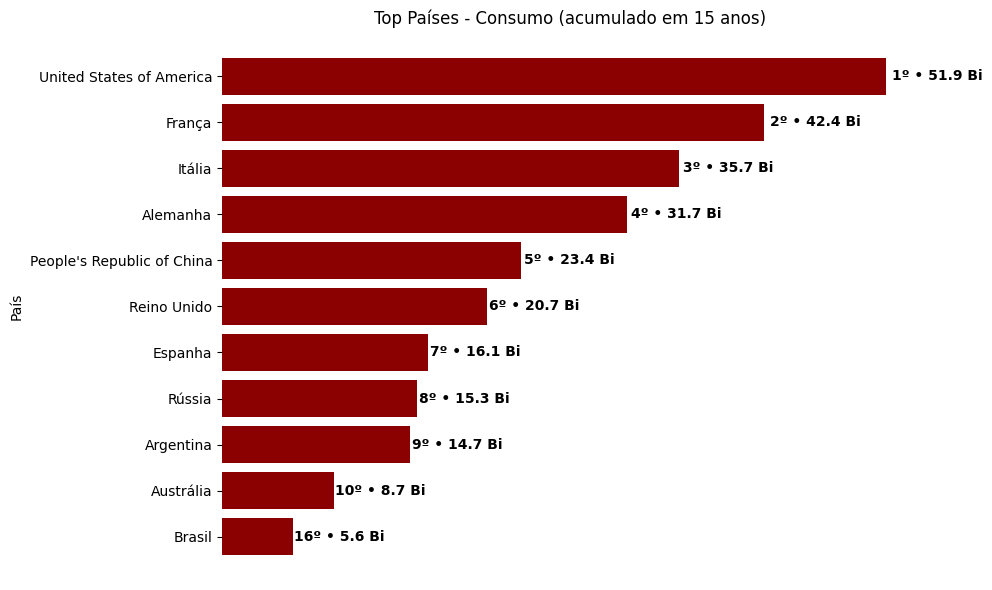

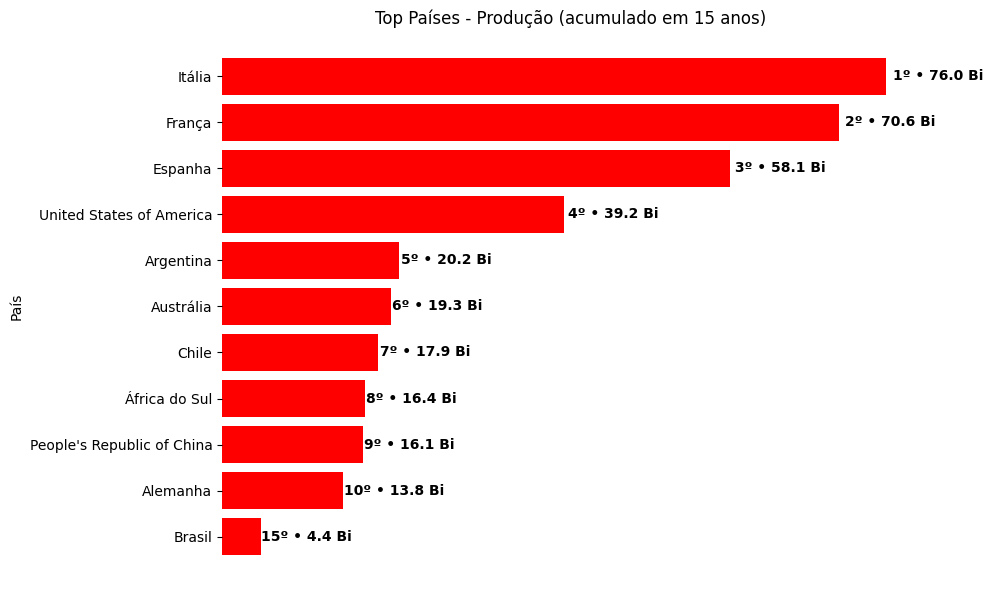

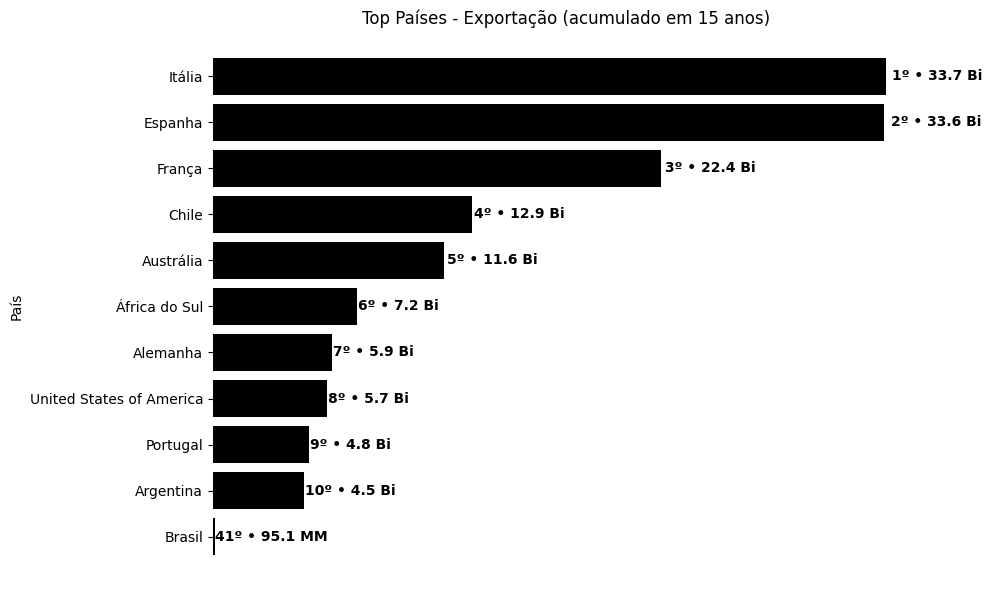

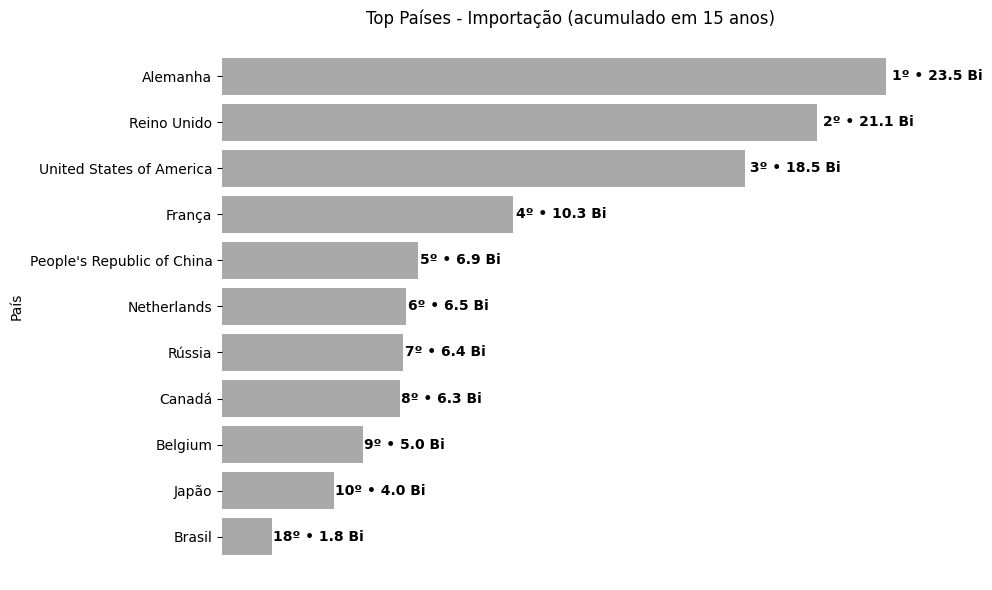

In [9]:

# Conversão correta: 1000 hectolitros * 100 litros
df['Litros'] = df['Quantity'] * 1000 * 100

# Tradução dos países
traducao_paises = {
    "Afghanistan": "Afeganistão",
    "Argentina": "Argentina",
    "Australia": "Austrália",
    "Austria": "Áustria",
    "Brazil": "Brasil",
    "Canada": "Canadá",
    "Chile": "Chile",
    "China": "China",
    "France": "França",
    "Germany": "Alemanha",
    "Greece": "Grécia",
    "Italy": "Itália",
    "Japan": "Japão",
    "Mexico": "México",
    "New Zealand": "Nova Zelândia",
    "Portugal": "Portugal",
    "Russia": "Rússia",
    "South Africa": "África do Sul",
    "Spain": "Espanha",
    "United Kingdom": "Reino Unido",
    "United States": "Estados Unidos",
}
df['País'] = df['Region/Country'].replace(traducao_paises)

# Excluir continentes e 'Global'
continentes = ['Asia', 'Africa', 'Europe', 'Oceania', 'Americas', 'America', 'Central America', 'South America']
filtro_excluir = ~df['Region/Country'].isin(continentes) & (df['Region/Country'] != 'Global')
df_filtrado = df[filtro_excluir].copy()

# Agrupar por variável e país
df_agg_corrigido_completo = df_filtrado.groupby(['Variable', 'País'], as_index=False)['Litros'].sum()

# Adicionar Brasil com 0 litros se não estiver em alguma alavanca
for var in ['Consumption', 'Production', 'Exports', 'Imports']:
    if not ((df_agg_corrigido_completo['Variable'] == var) & (df_agg_corrigido_completo['País'] == 'Brasil')).any():
        df_agg_corrigido_completo = pd.concat([
            df_agg_corrigido_completo,
            pd.DataFrame([{'Variable': var, 'País': 'Brasil', 'Litros': 0}])
        ], ignore_index=True)

# Calcular ranking por alavanca
def incluir_brasil_no_ranking(df_var):
    df_sorted = df_var.sort_values(by='Litros', ascending=False).reset_index(drop=True)
    df_sorted['Ranking'] = df_sorted.index + 1
    return df_sorted

# Gerar ranking completo com Brasil incluso
ranking_final_v2 = []
for var in ['Consumption', 'Production', 'Exports', 'Imports']:
    df_var = df_agg_corrigido_completo[df_agg_corrigido_completo['Variable'] == var]
    df_ranked = incluir_brasil_no_ranking(df_var)
    ranking_final_v2.append(df_ranked)

ranking_final_v2 = pd.concat(ranking_final_v2, ignore_index=True)

# Dicionários auxiliares
cores = {'Consumption': 'darkred', 'Production': 'red', 'Exports': 'black', 'Imports': 'darkgrey'}
titulo_traduzido = {
    'Consumption': 'Consumo',
    'Production': 'Produção',
    'Exports': 'Exportação',
    'Imports': 'Importação'
}

# Função para formatar valores grandes
def formatar_valor(valor):
    if valor >= 1_000_000_000_000:
        return f'{valor / 1_000_000_000_000:.1f} Tri'
    elif valor >= 1_000_000_000:
        return f'{valor / 1_000_000_000:.1f} Bi'
    elif valor >= 1_000_000:
        return f'{valor / 1_000_000:.1f} MM'
    else:
        return f'{valor:,.0f}'

# Função: top 10 + Brasil
def top10_e_brasil(df_var):
    top10 = df_var.head(10)
    brasil_row = df_var[df_var['País'] == 'Brasil']
    if 'Brasil' not in top10['País'].values:
        top10 = pd.concat([top10, brasil_row], ignore_index=True)
    return top10.sort_values(by='Litros', ascending=True)

# Gerar os gráficos
for var in cores.keys():
    dados_var = ranking_final_v2[ranking_final_v2['Variable'] == var]
    dados = top10_e_brasil(dados_var)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(dados['País'], dados['Litros'], color=cores[var])
    plt.title(f'Top Países - {titulo_traduzido[var]} (acumulado em 15 anos)')
    plt.ylabel('País')
    plt.xticks([])  # Sem eixo x

    for i, bar in enumerate(bars):
        largura = bar.get_width()
        pais = dados.iloc[i]['País']
        ranking = dados.iloc[i]['Ranking']
        label = f"{ranking}º • {formatar_valor(largura)}"
        plt.text(largura + largura * 0.01, bar.get_y() + bar.get_height()/2,
                 label, va='center', color='black', fontweight='bold')
    plt.grid(False)  # Remove grid
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.tight_layout()
    plt.show()

In [14]:
continentes = ['Asia', 'Africa', 'Europe', 'Oceania', 'Americas', 'America', 'Central America', 'South America']
df = df[~df['Region/Country'].isin(continentes) & (df['Region/Country'] != 'Global')]

# Identificar os dois últimos anos
anos_recentes = sorted(df['Year'].unique())[-2:]

# Filtrar só os dois últimos anos
df_ultimos2 = df[df['Year'].isin(anos_recentes)]

# Agrupar e pivotar para calcular variação
df_comp = df_ultimos2.groupby(['Variable', 'País', 'Year'], as_index=False)['Litros'].sum()
df_pivot = df_comp.pivot(index=['Variable', 'País'], columns='Year', values='Litros').reset_index()
df_pivot['Variação Absoluta'] = df_pivot[anos_recentes[1]] - df_pivot[anos_recentes[0]]
df_pivot['Variação Percentual (%)'] = (df_pivot['Variação Absoluta'] / df_pivot[anos_recentes[0]]) * 100

# Separar tabelas por alavanca
prod = df_pivot[df_pivot['Variable'] == 'Production'].nsmallest(10, 'Variação Absoluta')
cons = df_pivot[df_pivot['Variable'] == 'Consumption'].nsmallest(10, 'Variação Absoluta')
exp = df_pivot[df_pivot['Variable'] == 'Exports'].nsmallest(10, 'Variação Absoluta')
imp = df_pivot[df_pivot['Variable'] == 'Imports'].nsmallest(10, 'Variação Absoluta')


In [16]:
imp

Year,Variable,País,2023,2024,Variação Absoluta,Variação Percentual (%)
355,Imports,Alemanha,1.366400e+09,1.271700e+09,-94700000.0,-6.930621
444,Imports,Portugal,2.893000e+08,2.084000e+08,-80900000.0,-27.964051
421,Imports,Lithuania,9.970000e+07,3.180000e+07,-67900000.0,-68.104313
420,Imports,Latvia,1.126000e+08,4.800000e+07,-64600000.0,-57.371226
398,Imports,França,5.967000e+08,5.391000e+08,-57600000.0,-9.653092
432,Imports,Netherlands,4.413000e+08,3.939000e+08,-47400000.0,-10.740993
457,Imports,Switzerland,1.685000e+08,1.301000e+08,-38400000.0,-22.789318
372,Imports,Brasil,1.800000e+08,1.595000e+08,-20500000.0,-11.388889
365,Imports,Belgium,3.027000e+08,2.825000e+08,-20200000.0,-6.673274
448,Imports,Romania,6.000000e+07,4.240000e+07,-17600000.0,-29.333333


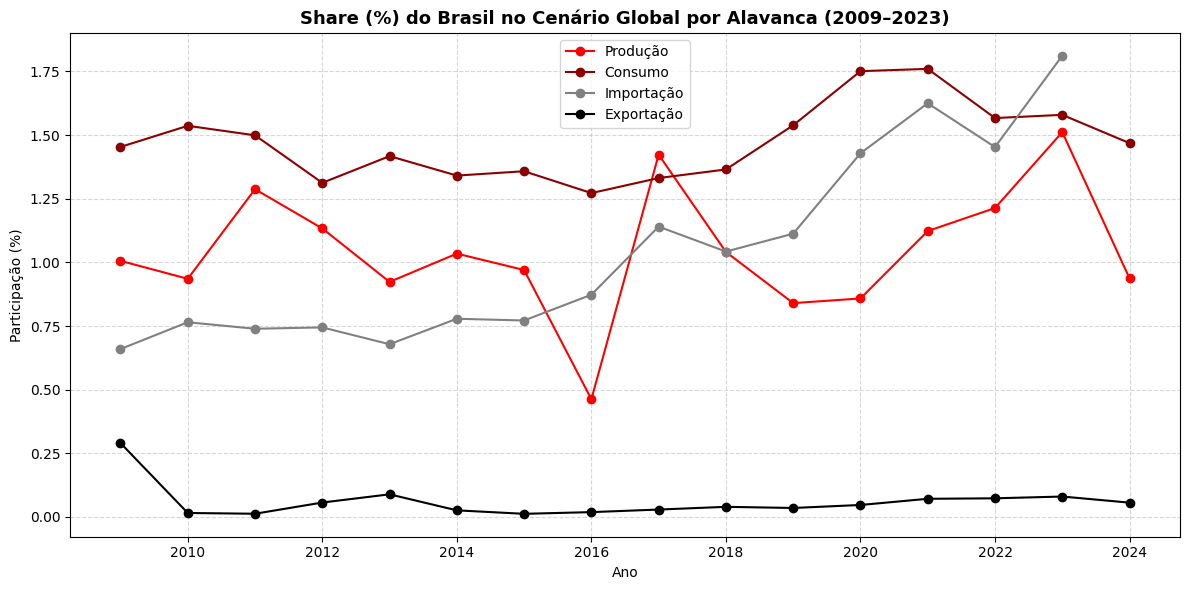

In [4]:
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')

# 3. Filtrar Brasil e Global
df_brasil = df[df['Region/Country'] == 'Brazil']
df_global = df[df['Region/Country'] == 'Global']

# 4. Variáveis de interesse (alavancas)
variaveis = ['Consumption', 'Imports', 'Exports', 'Production']

# 5. Calcular o share Brasil / Global por ano para cada alavanca
share_dict = {}
for var in variaveis:
    df_b_var = df_brasil[df_brasil['Variable'] == var].groupby('Year')['Quantity'].sum()
    df_g_var = df_global[df_global['Variable'] == var].groupby('Year')['Quantity'].sum()
    share = (df_b_var / df_g_var) * 100
    share_dict[var] = share

# 6. Criar DataFrame com os shares
df_share = pd.DataFrame(share_dict)

# 7. Traduzir colunas para português
df_share.columns = ['Consumo', 'Importação', 'Exportação', 'Produção']

# 8. Plotar gráfico com cores específicas
plt.figure(figsize=(12, 6))

plt.plot(df_share.index, df_share['Produção'], marker='o', label='Produção', color='red')
plt.plot(df_share.index, df_share['Consumo'], marker='o', label='Consumo', color='darkred')
plt.plot(df_share.index, df_share['Importação'], marker='o', label='Importação', color='grey')
plt.plot(df_share.index, df_share['Exportação'], marker='o', label='Exportação', color='black')

plt.title('Share (%) do Brasil no Cenário Global por Alavanca (2009–2023)', fontsize=13, weight='bold')
plt.xlabel('Ano')
plt.ylabel('Participação (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()